# Preprocess

(704, 13)
(704,)
(161, 13)
(161,)

(704, 1, 13)
(704,)
(161, 1, 13)
(161,)


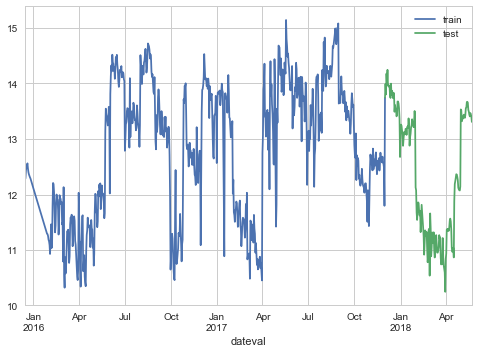

In [8]:
import keras
import pandas as pd
import pandasql as ps
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from pandas import DataFrame
from sklearn.model_selection import TimeSeriesSplit
from typing import Set, Any
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)
np.seterr(divide='ignore', invalid='ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential # Tells you which is the backend used (i.e. Tensorflow)
from keras.layers import Dense  # The same Keras code is used for each backend.
from keras.optimizers import Adam, SGD

from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.layers import Dropout

from keras.layers import LSTM
from keras.layers import Dropout


df = pd.read_csv("data/data.csv")
df = ps.sqldf("""select * from df order by dateval asc""")
df = df[["dateval", "log_y"]]
df["dateval"] = pd.to_datetime(df["dateval"])
df = df.set_index("dateval")

df['log_y_tomorrow'] = df['log_y'].shift(-1)
df = df.dropna()

df = df.iloc[0:890]
split_date = pd.Timestamp("2017-12-01")

train = df.loc[:split_date, ['log_y']]
test = df.loc[split_date:, ['log_y']]

ax = train['log_y'].plot()
test['log_y'].plot(ax=ax)
plt.legend(['train', 'test'])

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

for column in train.columns:
    train[[column]] = sc.fit_transform(train[[column]])
    test[[column]] = sc.transform(test[[column]])

train['tomorrow_log_y'] = train['log_y'].shift(-1)    
test['tomorrow_log_y'] = test['log_y'].shift(-1)    

for s in range(1, 13):
    train['log_y_lag_{}'.format(s)] = train['log_y'].shift(s)
    test['log_y_lag_{}'.format(s)] = test['log_y'].shift(s)

train = train.dropna()
test = test.dropna()

X_train = train.drop("tomorrow_log_y", axis=1).values
y_train = train['tomorrow_log_y'].values

X_test = test.drop("tomorrow_log_y", axis=1).values
y_test = test['tomorrow_log_y'].values

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print()

features = X_train.shape[1]

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Functions

In [9]:
X_train.shape[1:]

(1, 13)

In [20]:
from keras.layers import BatchNormalization
def repeated_training(X_train,
                      y_train,
                      X_test,
                      y_test,
                      lstm_units=32,
                      units=512,
                      activation='relu',
                      optimizer='sgd',
                      do_bn=False,
                      epochs=10,
                      repeats=3):
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()

        model = Sequential()
        
        # first fully connected layer
        model.add(LSTM(lstm_units,
                        input_shape=X_train.shape[1:],
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # second fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # third fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # output layer
        model.add(Dense(1))
        
        model.compile(optimizer,
                      loss="mean_squared_error", 
                      lr= 0.005)

        h = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=epochs,
                      verbose=0)
        histories.append([h.history['loss'], h.history['val_loss']])
        print(repeat, end=' ')

    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_loss = histories.mean(axis=0)
    std_loss = histories.std(axis=0)
    print()
    
    return mean_loss[0], std_loss[0], mean_loss[1], std_loss[1]


In [35]:
from math import sqrt
np.array([1,2,3,4]).apply(lambda x: sqrt(x))

AttributeError: 'numpy.ndarray' object has no attribute 'apply'

In [21]:
mean_loss, std_loss, mean_loss_val, std_loss_val = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=False)

/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))
/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


0 

/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))
/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


1 

/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))
/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


2 


In [22]:
mean_loss_bn, std_loss_bn, mean_loss_val_bn, std_loss_val_bn = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=True)

/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))
/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


0 

/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))
/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


1 

/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))
/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


2 


In [23]:
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.3)

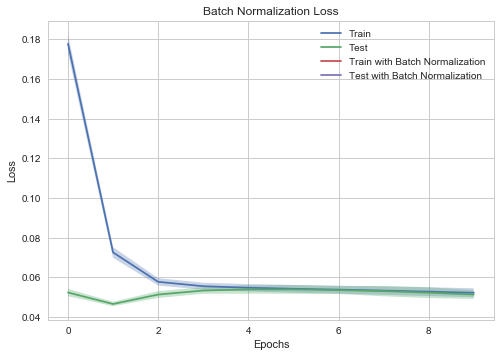

In [27]:
plot_mean_std(mean_loss, std_loss)
plot_mean_std(mean_loss_val, std_loss_val)
plot_mean_std(mean_loss_bn, std_loss_bn)
plot_mean_std(mean_loss_val_bn, std_loss_val_bn)

plt.title("Batch Normalization Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test', 'Train with Batch Normalization', 'Test with Batch Normalization'], loc='best')


In [28]:
mean_loss_bn, std_loss_bn

(array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan]),
 array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan]))

In [18]:
print(mean_acc, std_acc)
# plot_mean_std(mean_acc_val, std_acc_val)
# plot_mean_std(mean_acc_bn, std_acc_bn)
# plot_mean_std(mean_acc_val_bn, std_acc_val_bn)

[ 0.1833443   0.07581217  0.05813073  0.0550618   0.0541378   0.05358746
  0.05308682  0.0525982   0.05211488  0.05162687] [ 0.00239829  0.00157672  0.00022782  0.00021298  0.00030341  0.00032981
  0.00034979  0.00036692  0.00032265  0.00029197]


# Train

# Evaluate

In [15]:
y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error
from math import sqrt
y_test_mean = y_test.mean()

baseline_average = np.zeros(len(y_test))
baseline_average.fill(y_test_mean)

baseline_yesterday = np.concatenate(([y_train[-1]], y_test[:-1]))

rmse = sqrt(mean_squared_error(y_test, y_pred))
model_pct_off = rmse / y_test_mean

baseline_average_pct_off = sqrt(mean_squared_error(y_test, baseline_average)) / y_test_mean
pct_improvement_over_baseline_average = (model_pct_off/baseline_average_pct_off - 1)*-1

baseline_yesterday_pct_off = sqrt(mean_squared_error(y_test, baseline_yesterday)) / y_test_mean
pct_improvement_over_baseline_yesterday = (model_pct_off/baseline_yesterday_pct_off - 1)*-1

print("Average amount off = {}".format(rmse))
print("Model off = {:.2%}".format(model_pct_off))
print()
print("Baseline average prediction off = {:.2%}".format(baseline_average_pct_off))
print("Better than baseline average prediction = {:.2%}".format(pct_improvement_over_baseline_average))
print()
print("Baseline yesterday prediction off = {:.2%}".format(baseline_yesterday_pct_off))
print("Better than baseline yesterday prediction = {:.2%}".format(pct_improvement_over_baseline_yesterday))
plt.plot(y_test)
plt.plot(y_pred)
plt.ylabel('log_y')
plt.xlabel('date')
plt.legend(['y_test', 'y_pred'], loc='lower left')
plt.show()

NameError: name 'model' is not defined